# AGS-GNN Graph Sampling

In [22]:
import sys
sys.path.append('../Submodular')

import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

In [23]:
from ipynb.fs.full.Dataset import get_data
from ipynb.fs.full.Dataset import datasets as available_datasets
from ipynb.fs.full.Utils import save_plot

In [24]:
import argparse
from argparse import ArgumentParser

#set default arguments here
def get_configuration():
    parser = ArgumentParser()
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--log_info', type=bool, default=True)
    parser.add_argument('--recompute', type=bool, default=False)
    parser.add_argument('--pbar', type=bool, default=False)
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--dataset', type=str, default="Cora", choices=available_datasets)
    parser.add_argument('--use_normalization', action='store_true', default=True)    
    parser.add_argument('-f') ##dummy for jupyternotebook
    
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

In [25]:
import random
import numpy as np
import torch

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
None

## GNN model

In [26]:
import os
import math
import time
import torch_geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, ChebConv
from torch_geometric.nn import GraphConv, TransformerConv
from torch_geometric.utils import degree
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from ipynb.fs.full.SpatialConv import SpatialConv
from tqdm import tqdm
import torch.nn as nn

## Homophilic GNN

In [27]:
class HomophilicNet(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, end_hidden):
        super().__init__()
        in_channels = num_features
        out_channels = num_classes
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
#         self.conv3 = GraphConv(hidden_channels, hidden_channels)
#         self.lin = torch.nn.Linear(3 * hidden_channels, end_hidden)
#         self.lin2 = torch.nn.Linear(3 * hidden_channels, out_channels)
        self.lin = torch.nn.Linear(2 * hidden_channels, end_hidden)
        self.lin2 = torch.nn.Linear(2 * hidden_channels, out_channels)


    def set_aggr(self, aggr):
        self.conv1.aggr = aggr
        self.conv2.aggr = aggr
#         self.conv3.aggr = aggr

    def forward(self, x0, edge_index, edge_weight=None):
        x1 = F.relu(self.conv1(x0, edge_index, edge_weight))
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = F.relu(self.conv2(x1, edge_index, edge_weight))
        x2 = F.dropout(x2, p=0.2, training=self.training)
#         x3 = F.relu(self.conv3(x2, edge_index, edge_weight))
#         x3 = F.dropout(x3, p=0.2, training=self.training)
#         x = torch.cat([x1, x2, x3], dim=-1)

        x = torch.cat([x1, x2], dim=-1)
        
        c1 = self.lin(x)
        c2 = self.lin2(x)
        
        return F.relu(c1), c2.log_softmax(dim=-1)

## Heterophilic GNN

In [28]:
#replace this part with ACMGCN

In [29]:
class HeterophilicNet(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, end_hidden):
        super().__init__()
        in_channels = num_features
        out_channels = num_classes
        self.conv1 = ChebConv(in_channels, hidden_channels, K=1, normalization='sym')
        self.conv2 = ChebConv(hidden_channels, hidden_channels, K=1, normalization='sym')
#         self.conv3 = ChebConv(hidden_channels, hidden_channels, K=1, normalization='sym')
#         self.lin = torch.nn.Linear(3 * hidden_channels, end_hidden)
#         self.lin2 = torch.nn.Linear(3 * hidden_channels, out_channels)

        self.lin = torch.nn.Linear(2 * hidden_channels, end_hidden)
        self.lin2 = torch.nn.Linear(2 * hidden_channels, out_channels)


    def set_aggr(self, aggr):
        self.conv1.aggr = aggr
        self.conv2.aggr = aggr
#         self.conv3.aggr = aggr

    def forward(self, x0, edge_index, edge_weight=None):
        x1 = F.relu(self.conv1(x0, edge_index, edge_weight))
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = F.relu(self.conv2(x1, edge_index, edge_weight))
        x2 = F.dropout(x2, p=0.2, training=self.training)
#         x3 = F.relu(self.conv3(x2, edge_index, edge_weight))
#         x3 = F.dropout(x3, p=0.2, training=self.training)
#         x = torch.cat([x1, x2, x3], dim=-1)
        x = torch.cat([x1, x2], dim=-1)
        
        c1 = self.lin(x)
        c2 = self.lin2(x)
        
        return F.relu(c1), c2.log_softmax(dim=-1)

## Combination Network

In [30]:
class AGSGNN(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=256, dropout=0.5):
        super().__init__()
        self.num_classes = num_classes
        
        hidden = int(hidden_channels/2)        
        self.gnn1 = HomophilicNet(num_features, num_classes, hidden_channels, hidden)
#         self.gnn2 = HeterophilicNet(num_features, num_classes, hidden_channels, hidden)
        self.gnn2 = HomophilicNet(num_features, num_classes, hidden_channels, hidden)

        self.p = dropout
        self.com_lin = nn.Linear(hidden*2, num_classes)      
        
    def forward(self, batch_data):
        
        #out = model(batch_data.x, batch_data.edge_index, batch_data.edge_weight)
        #out = model(batch_data.x, batch_data.edge_index)
        
        x1, x1c1 = self.gnn1(batch_data[0].x, batch_data[0].edge_index, batch_data[0].weight)
        x2, x2c2 = self.gnn2(batch_data[1].x, batch_data[1].edge_index, batch_data[1].weight)

#         x1 = self.gnn1(batch_data[0].x, batch_data[0].edge_index)
#         x2 = self.gnn2(batch_data[1].x, batch_data[1].edge_index)

        a1 = F.relu(x1)
        a1 = F.dropout(a1, p=self.p, training=self.training)
        
        s1 = F.relu(x2)        
        s1 = F.dropout(s1, p=self.p, training=self.training)
        
        batch_size = batch_data[0].batch_size        
        x = torch.cat([a1[:batch_size,:], s1[:batch_size,:]], dim=-1)
        x = self.com_lin(x)
        
        #return x
    
        return x.log_softmax(dim=-1), x1c1, x2c2

## GNN Training and Testing

In [31]:
from ipynb.fs.full.a2AGS_Graph_Sampler import AGSGraphSampler
from torch_geometric.loader import NeighborSampler, NeighborLoader

In [32]:
from collections import Counter
import random

def prediction(y_pred_seed, y_pred_hm, y_pred_ht):
    
    all_tensors = [y_pred_seed, y_pred_hm, y_pred_ht]
    final_predictions = []

    for i in range(len(y_pred_seed)):
        values_at_index = [tensor[i].item() for tensor in all_tensors]
        counter = Counter(values_at_index)
        most_common_values = counter.most_common()

        # Check if there's a tie
        if len(most_common_values) > 1 and most_common_values[0][1] == most_common_values[1][1]:
            #selected_value = random.choice([value for value, count in most_common_values[:2]])
            selected_value = y_pred_seed[i].item()
        else:
            selected_value = most_common_values[0][0]

        final_predictions.append(selected_value)
            
    return torch.LongTensor(final_predictions)

y_pred_seed = torch.tensor([0, 1, 2, 2, 1])
y_pred_hm = torch.tensor([2, 1, 1, 0, 2])
y_pred_ht = torch.tensor([0, 2, 1, 1, 0])


# prediction(y_pred_seed,y_pred_hm,y_pred_ht)

In [33]:
def test(model, loader, mask, name='Train', channel='all'):
    if args.log_info:
        pbar = tqdm(total=sum(mask).item())
        pbar.set_description(f'Evaluating {name}')

    model.eval()
    
    total_correct=0
    total_examples=0
    
    with torch.no_grad():                  
    
        for i,batch_data in enumerate(loader):
            
            batch_data = [b_data.to(device) for b_data in batch_data]
            batch_size = batch_data[0].batch_size
            batch_data[0].weight = batch_data[0].edge_norm * batch_data[0].edge_weight
            batch_data[1].weight = batch_data[1].edge_norm * batch_data[1].edge_weight
            
            out, out1, out2 = model(batch_data)
                
            #print(out.shape, out1.shape, out2.shape)
            
            y_pred_seed = out[:batch_size].argmax(dim=-1).cpu()
            y_pred_hm = out1[:batch_size].argmax(dim=-1).cpu()
            y_pred_ht = out2[:batch_size].argmax(dim=-1).cpu()
            
            #print(y_pred_seed.shape,y_pred_hm.shape, y_pred_ht.shape)
            
            
            y_true = batch_data[0].y[:batch_size]
            
            if name == 'Train':
                t_mask = batch_data[0].train_mask[:batch_size]
            elif name == 'Validation':
                t_mask = batch_data[0].val_mask[:batch_size]
            else:
                t_mask = batch_data[0].test_mask[:batch_size]

            if channel=='sd':
                y_pred = y_pred_seed
            elif channel=='hm':
                y_pred = y_pred_hm
            elif channel=='ht':
                y_pred = y_pred_ht
            else:
                y_pred = prediction(y_pred_seed, y_pred_hm, y_pred_ht)

            #print(y_pred)                
            correct = y_pred.eq(y_true.cpu())
            total_correct+= correct[t_mask].sum().item()
            
            items = t_mask.sum().item()
            total_examples+= items           
            
            if args.log_info:
                pbar.update(items)
    
    if args.log_info:
        pbar.close()

    return total_correct/total_examples

In [34]:
#https://github.com/GraphSAINT/GraphSAINT/issues/11
    
def train(DATASET_NAME,model, data, dataset, epochs=1, channel='all'): #'all', 'hm', 'ht', 'sd'
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)    
    if data.y.ndim == 1:
        criterion = torch.nn.CrossEntropyLoss() #regular logits as output
#         criterion = torch.nn.NLLLoss() ## if log softmax used as activation
    else:
        criterion = torch.nn.BCEWithLogitsLoss()     #multillabel
    
    row, col = data.edge_index
    data.edge_weight = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.
    
    sampler_dir = DIR+'AGSGSAINTCHEB/'+DATASET_NAME
    if not os.path.exists(sampler_dir):
        os.makedirs(sampler_dir)
        
    batch_size= min(1024, data.num_nodes)
    #num_steps=math.ceil(sum (data.train_mask)/batch_size)    
    num_steps=math.ceil(data.num_nodes/batch_size)
    num_workers = 8  if data.num_nodes>50000 else 0
    
    sample_func =['wrw', 'wrw']
    weight_func =[
        {'exact':False,'weight':'fastlink'}, #exact for exact size to the batch
        {'exact':False,'weight':'fastlink'}
    ]

    params={'knn':{'metric':'cosine'},
            'submodular':{'metric':'cosine'},
            'link-nn':{'value':'min'},
            'link-sub':{'value':'max'},
            'disjoint':{'value':'mst'},
           }
    
    loader = AGSGraphSampler(
        data, batch_size=batch_size, walk_length=2, num_steps=num_steps, sample_coverage=100,
        num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,recompute = args.recompute, shuffle = False,
        sample_func = sample_func, weight_func=weight_func, params=params)
        
    
    #for evaluation
    train_num_steps = int(torch.ceil(sum(data.train_mask)/batch_size))
    val_num_steps = int(torch.ceil(sum(data.val_mask)/batch_size))
    test_num_steps = int(torch.ceil(sum(data.test_mask)/batch_size))
    
    train_loader = AGSGraphSampler(
        data, input_nodes = data.train_mask, batch_size=batch_size, walk_length=2, num_steps=train_num_steps, 
        sample_coverage=100,num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,
        recompute = False, shuffle = False,sample_func = sample_func, weight_func=weight_func, params=params)
    
    
    val_loader = AGSGraphSampler(
        data, input_nodes = data.val_mask, batch_size=batch_size, walk_length=2, num_steps=val_num_steps, 
        sample_coverage=100,num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,
        recompute = False, shuffle = False,sample_func = sample_func, weight_func=weight_func, params=params)
        
    test_loader = AGSGraphSampler(
        data, input_nodes = data.test_mask, batch_size=batch_size, walk_length=2, num_steps=test_num_steps, 
        sample_coverage=100,num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,
        recompute = False, shuffle = False,sample_func = sample_func, weight_func=weight_func, params=params)
            
    best_acc=0    
    train_losses = []; val_accuracies = []; train_accuracies = []; test_accuracies = []    
    max_iteration = epochs    
    
    th_node = 10000
    
    if data.num_nodes<th_node:  
        test_data = data.clone()
        test_data.weight = loader.edge_norm * test_data.edge_weight
        test_data.seed_node=torch.arange(test_data.num_nodes)  
        test_data.batch_size=test_data.seed_node.shape[0]
        all_data = [test_data.to(device), test_data.to(device)]    
        
        if args.log_info:
            print(all_data)
        
    
    for epoch in range(1,epochs+1):
        
        if args.log_info:
            pbar = tqdm(total=batch_size*num_steps)
            pbar.set_description(f'Epoch {epoch:02d}')
        
        model.train()
        #if model.__class__.__name__ == 'Net':
            #model.set_aggr('add' if args.use_normalization else 'mean')
        model.gnn1.set_aggr('add' if args.use_normalization else 'mean')
        model.gnn2.set_aggr('add' if args.use_normalization else 'mean')

        total_loss = total_examples = 0
        total_loss_seed = total_loss_hm = total_loss_ht = 0
        total_seed_example = total_hm_example = total_ht_example = 0
                    
        for i,batch_data in enumerate(loader):
            
            #print(batch_data);
            #print("*"*50)            
            
            batch_data = [b_data.to(device) for b_data in batch_data]
                    
            batch_size = batch_data[0].batch_size
            mask = batch_data[0].train_mask[:batch_size]
            y_true = batch_data[0].y[:batch_size]
            
            if torch.sum(mask) == 0:
                if args.log_info:
                    print("no training mask in seed node")
#                 continue

            optimizer.zero_grad()
            if args.use_normalization:                 
                
                batch_data[0].weight = batch_data[0].edge_norm * batch_data[0].edge_weight
                batch_data[1].weight = batch_data[1].edge_norm * batch_data[1].edge_weight
                out, out1, out2 = model(batch_data)                            
                #print(out.shape, out1.shape, out2.shape)
                
                                
#                 print(out[:batch_size][mask].shape, y_true[mask].shape)                
#                 print(loss.shape)
#                 print(batch_data[0].node_norm.shape)
#                 print(batch_data[0].node_norm[:batch_size].shape)
#                 loss = criterion(out, batch_data.y, reduction='none')

                #--------- loss computation seed nodes --------- #                
                loss_seed = F.nll_loss(out[:batch_size][mask], y_true[mask], reduction='none')
                loss_seed = (loss_seed * batch_data[0].node_norm[:batch_size][mask]).sum()
        
                #--------- loss computation homophily nodes --------- #
            
                loss_hm = F.nll_loss(out1[batch_data[0].train_mask], batch_data[0].y[batch_data[0].train_mask], reduction='none')
                loss_hm = (loss_hm * batch_data[0].node_norm[batch_data[0].train_mask]).sum()
                
                #--------- loss computation homophily nodes --------- #
                loss_ht = F.nll_loss(out2[batch_data[1].train_mask], batch_data[1].y[batch_data[1].train_mask], reduction='none')
                loss_ht = (loss_ht * batch_data[1].node_norm[batch_data[1].train_mask]).sum()
                
                if channel=='sd':loss = loss_seed
                elif channel=='hm':loss = loss_hm
                elif channel=='ht':loss = loss_ht
                else:loss = loss_seed + loss_hm + loss_ht                

            else:
                batch_data[0].weight = None
                batch_data[1].weight = None
                    
                out, out1, out2 = model(batch_data)                            
                #print(out.shape, out1.shape, out2.shape)
                
                mask = batch_data[0].train_mask[:batch_size]
                y_true = batch_data[0].y[:batch_size]
                
                #--------- loss computation seed nodes --------- #                
                loss_seed = F.nll_loss(out[:batch_size][mask], y_true[mask])
                
                #--------- loss computation homophily nodes --------- #
                loss_hm = F.nll_loss(out1[batch_data[0].train_mask], batch_data[0].y[batch_data[0].train_mask])
                
                #--------- loss computation homophily nodes --------- #
                loss_ht = F.nll_loss(out2[batch_data[1].train_mask], batch_data[1].y[batch_data[1].train_mask])
                #loss = criterion(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])
                
                if channel=='sd':loss = loss_seed
                elif channel=='hm':loss = loss_hm
                elif channel=='ht':loss = loss_ht
                else:loss = loss_seed + loss_hm + loss_ht
                
                
                        
            loss.backward()
            optimizer.step()
            
            total_loss_seed+= loss_seed.item()*batch_size
            total_loss_hm+= loss_hm.item()*sum(batch_data[0].train_mask).item()
            total_loss_ht+= loss_ht.item()*sum(batch_data[1].train_mask).item()
            
            total_seed_example+= sum(mask).item()
            total_hm_example+=sum(batch_data[0].train_mask).item()
            total_ht_example+=sum(batch_data[1].train_mask).item()
            
            if args.log_info:
                pbar.update(batch_size)
        
        if args.log_info:
            pbar.close()
            
        total_loss_seed /= max(total_seed_example,1)
        total_loss_hm /= max(total_hm_example, 1)
        total_loss_ht /= max(total_ht_example, 1)
        
        total_loss=total_loss_seed+total_loss_hm+total_loss_ht
        total_examples = total_seed_example + total_hm_example + total_ht_example
        
        if args.log_info:
            print(f'Loss:{total_loss:0.4f} seed:{total_loss_seed:0.4f} hm:{total_loss_hm:0.4f} ht:{total_loss_ht:0.4f}')
            print(f'Example:{total_examples:1d} seed:{total_seed_example:1d} hm:{total_hm_example:1d} ht:{total_ht_example:1d}')
        
        if channel=='sd':train_losses.append(total_loss_seed)
        elif channel=='hm':train_losses.append(total_loss_hm)
        elif channel=='ht':train_losses.append(total_loss_ht)
        else:train_losses.append(total_loss)
                        
        accs = [0,0,0]
        
        model.eval()
#         model.gnn1.set_aggr('mean')
#         model.gnn2.set_aggr('mean')
        model.gnn1.set_aggr('add' if args.use_normalization else 'mean')
        model.gnn2.set_aggr('add' if args.use_normalization else 'mean')
        
        
        if data.num_nodes<th_node:
                        
            with torch.no_grad():
                out, out1, out2 = model(all_data)
                
                #print(out.shape, out1.shape, out2.shape)
                y_pred_seed = out.argmax(dim=-1).cpu()
                y_pred_hm = out1.argmax(dim=-1).cpu()
                y_pred_ht = out2.argmax(dim=-1).cpu()
                
                if channel=='sd':
                    y_pred = y_pred_seed
                elif channel=='hm':
                    y_pred = y_pred_hm
                elif channel=='ht':
                    y_pred = y_pred_ht
                else:
                    y_pred = prediction(y_pred_seed, y_pred_hm, y_pred_ht)
                
                #print(y_pred)                
                correct = y_pred.eq(data.y.cpu())
                accs = []
                for _, mask in data('train_mask', 'val_mask', 'test_mask'):
                    accs.append(correct[mask].sum().item() / mask.sum().item()) 
                                                    
        else:
            accs[0] = test(model, train_loader, data.train_mask, name='Train', channel=channel)
            accs[1] = test(model, val_loader, data.val_mask, name='Validation', channel=channel)
            accs[2] = test(model, test_loader, data.test_mask, name='Test', channel=channel)
            
        train_accuracies.append(accs[0])
        val_accuracies.append(accs[1])
        test_accuracies.append(accs[2])
        std_dev = np.std(train_losses[-5:])
        
        if args.log_info:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {accs[0]:.4f}, Val: {accs[1]:.4f}, Test: {accs[2]:.4f}, Std dev: {std_dev:.4f}')
        
        if epoch>=5 and std_dev<=1e-4:
            if args.log_info:
                print("Iteration for convergence: ", epoch)
            max_iteration = epoch
            break
    
    if args.log_info:
        save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Results/AGSGSValidation', yname='Accuracy', xname='Epoch')
        print ("Best Validation Accuracy, ",max(val_accuracies))
        print ("Best Test Accuracy, ",max(test_accuracies))
    
    if data.num_nodes<th_node:  
        del all_data
    
    return max(test_accuracies), max_iteration

In [35]:
def AGSGSperformanceSampler(DATASET_NAME,data, dataset, num_classes, epochs=1,channel='all'):
    
    model = AGSGNN(data.x.shape[1], num_classes, hidden_channels=256).to(device)            
    
    if args.log_info:
        print(model)

    itr, accuracy = train(DATASET_NAME, model, data, dataset, epochs, channel)
    
    return itr, accuracy, model

In [36]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

def adj_feature(data):    
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    edges = data.edge_index.t()
    adj_mat[edges[:,0], edges[:,1]] = 1
    adj_mat[edges[:,1], edges[:,0]] = 1
    
#     n_components = data.x.shape[1]
    n_components = min(256, data.x.shape[1], data.num_nodes)

    svd = TruncatedSVD(n_components=n_components)
    x = svd.fit_transform(adj_mat)
    
    x = torch.Tensor(x)
    x.shape    
    
    return x

# x = adj_feature(data)
# x.shape

N  2708  E  10556  d  3.8980797636632203 0.825157880783081 0.8099659085273743 0.7657181620597839 -0.06587088108062744 Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
AGSGNN(
  (gnn1): HomophilicNet(
    (conv1): GraphConv(1433, 256)
    (conv2): GraphConv(256, 256)
    (lin): Linear(in_features=512, out_features=128, bias=True)
    (lin2): Linear(in_features=512, out_features=7, bias=True)
  )
  (gnn2): HomophilicNet(
    (conv1): GraphConv(1433, 256)
    (conv2): GraphConv(256, 256)
    (lin): Linear(in_features=512, out_features=128, bias=True)
    (lin2): Linear(in_features=512, out_features=7, bias=True)
  )
  (com_lin): Linear(in_features=256, out_features=7, bias=True)
)
loading saved norm
Loading weights  fastlink
loading saved norm
Loading weights  fastlink
loading saved norm
Loading weights  fastlink
loading saved norm
Loading weights  fastlink
[Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], 

Epoch 01:  82%|████████▏ | 2520/3072 [00:00<00:00, 6443.92it/s]


Loss:1.1255 seed:1.0193 hm:0.0532 ht:0.0530
Example:393 seed:131 hm:131 ht:131
Epoch: 001, Train Loss: 0.1700, Train: 0.1643, Val: 0.1620, Test: 0.1490, Std dev: 0.0000


Epoch 02: : 2545it [00:00, 4677.54it/s]                        


Loss:1.1157 seed:1.0121 hm:0.0518 ht:0.0518
Example:390 seed:130 hm:130 ht:130
Epoch: 002, Train Loss: 0.1729, Train: 0.2714, Val: 0.1700, Test: 0.1640, Std dev: 0.0049


Epoch 03: : 2542it [00:00, 5836.46it/s]                        


Loss:1.0771 seed:0.9900 hm:0.0436 ht:0.0436
Example:333 seed:111 hm:111 ht:111
Epoch: 003, Train Loss: 0.1332, Train: 0.4786, Val: 0.2300, Test: 0.2310, Std dev: 0.0209


Epoch 04: 100%|█████████▉| 2561/2571 [00:00<00:00, 5756.05it/s]


Loss:1.1135 seed:1.0091 hm:0.0522 ht:0.0522
Example:390 seed:130 hm:130 ht:130
Epoch: 004, Train Loss: 0.1855, Train: 0.4286, Val: 0.2140, Test: 0.2300, Std dev: 0.0184


Epoch 05: : 2578it [00:00, 5981.22it/s]                        


Loss:1.1548 seed:1.0287 hm:0.0630 ht:0.0631
Example:480 seed:160 hm:160 ht:160
Epoch: 005, Train Loss: 0.1948, Train: 0.4643, Val: 0.2460, Test: 0.2490, Std dev: 0.0249


Epoch 06:  99%|█████████▊| 2549/2583 [00:00<00:00, 5777.38it/s]


Loss:1.1320 seed:1.0216 hm:0.0552 ht:0.0552
Example:420 seed:140 hm:140 ht:140
Epoch: 006, Train Loss: 0.1623, Train: 0.5429, Val: 0.2280, Test: 0.2270, Std dev: 0.0255


Epoch 07: : 2572it [00:00, 5819.83it/s]                        


Loss:1.0923 seed:0.9915 hm:0.0503 ht:0.0505
Example:399 seed:133 hm:133 ht:133
Epoch: 007, Train Loss: 0.1459, Train: 0.6286, Val: 0.2220, Test: 0.2340, Std dev: 0.0276


Epoch 08:  99%|█████████▊| 2565/2604 [00:00<00:00, 5058.90it/s]


Loss:1.1012 seed:0.9932 hm:0.0538 ht:0.0541
Example:423 seed:141 hm:141 ht:141
Epoch: 008, Train Loss: 0.1849, Train: 0.7500, Val: 0.3260, Test: 0.3290, Std dev: 0.0224


Epoch 09: 100%|█████████▉| 2580/2589 [00:00<00:00, 6959.61it/s]


Loss:1.0986 seed:0.9913 hm:0.0535 ht:0.0538
Example:423 seed:141 hm:141 ht:141
Epoch: 009, Train Loss: 0.1875, Train: 0.7500, Val: 0.3500, Test: 0.3440, Std dev: 0.0239


Epoch 10: : 2567it [00:00, 6432.58it/s]                        


Loss:1.0302 seed:0.9416 hm:0.0441 ht:0.0445
Example:363 seed:121 hm:121 ht:121
Epoch: 010, Train Loss: 0.1076, Train: 0.7286, Val: 0.3520, Test: 0.3410, Std dev: 0.0333


Epoch 11: : 2580it [00:00, 4433.27it/s]                        


Loss:1.0355 seed:0.9450 hm:0.0450 ht:0.0455
Example:381 seed:127 hm:127 ht:127
Epoch: 011, Train Loss: 0.1355, Train: 0.7714, Val: 0.3820, Test: 0.3830, Std dev: 0.0318


Epoch 12: 100%|█████████▉| 2570/2577 [00:00<00:00, 6595.54it/s]


Loss:0.9819 seed:0.8749 hm:0.0531 ht:0.0539
Example:483 seed:161 hm:161 ht:161
Epoch: 012, Train Loss: 0.1708, Train: 0.8357, Val: 0.5200, Test: 0.4960, Std dev: 0.0452


Epoch 13:  99%|█████████▊| 2552/2589 [00:00<00:00, 5832.87it/s]


Loss:0.9094 seed:0.8204 hm:0.0438 ht:0.0453
Example:414 seed:138 hm:138 ht:138
Epoch: 013, Train Loss: 0.1118, Train: 0.8571, Val: 0.5260, Test: 0.5000, Std dev: 0.0629


Epoch 14: 100%|█████████▉| 2558/2565 [00:00<00:00, 6110.23it/s]


Loss:0.8069 seed:0.7253 hm:0.0403 ht:0.0413
Example:414 seed:138 hm:138 ht:138
Epoch: 014, Train Loss: 0.1145, Train: 0.8429, Val: 0.4720, Test: 0.4730, Std dev: 0.0858


Epoch 15:  99%|█████████▉| 2551/2574 [00:00<00:00, 5387.97it/s]


Loss:0.7502 seed:0.6678 hm:0.0407 ht:0.0417
Example:444 seed:148 hm:148 ht:148
Epoch: 015, Train Loss: 0.1168, Train: 0.8857, Val: 0.5380, Test: 0.5240, Std dev: 0.1060


Epoch 16: 100%|█████████▉| 2557/2559 [00:00<00:00, 5186.67it/s]


Loss:0.6713 seed:0.5979 hm:0.0357 ht:0.0377
Example:420 seed:140 hm:140 ht:140
Epoch: 016, Train Loss: 0.0998, Train: 0.9000, Val: 0.5760, Test: 0.5710, Std dev: 0.1107


Epoch 17: : 2570it [00:00, 6695.15it/s]                        


Loss:0.5317 seed:0.4718 hm:0.0290 ht:0.0308
Example:396 seed:132 hm:132 ht:132
Epoch: 017, Train Loss: 0.0754, Train: 0.9143, Val: 0.5840, Test: 0.5750, Std dev: 0.1275


Epoch 18:  98%|█████████▊| 2571/2622 [00:00<00:00, 6534.01it/s]


Loss:0.4353 seed:0.3827 hm:0.0255 ht:0.0272
Example:381 seed:127 hm:127 ht:127
Epoch: 018, Train Loss: 0.0482, Train: 0.9357, Val: 0.5880, Test: 0.5720, Std dev: 0.1375


Epoch 19:  99%|█████████▉| 2552/2568 [00:00<00:00, 3937.63it/s]


Loss:0.3640 seed:0.3150 hm:0.0235 ht:0.0256
Example:393 seed:131 hm:131 ht:131
Epoch: 019, Train Loss: 0.0546, Train: 0.9500, Val: 0.6200, Test: 0.6150, Std dev: 0.1434


Epoch 20:  99%|█████████▉| 2551/2571 [00:00<00:00, 4950.11it/s]


Loss:0.2584 seed:0.2143 hm:0.0207 ht:0.0233
Example:435 seed:145 hm:145 ht:145
Epoch: 020, Train Loss: 0.0506, Train: 1.0000, Val: 0.7200, Test: 0.6960, Std dev: 0.1414


Epoch 21: 100%|██████████| 2553/2553 [00:00<00:00, 5539.69it/s]


Loss:0.2201 seed:0.1844 hm:0.0169 ht:0.0187
Example:402 seed:134 hm:134 ht:134
Epoch: 021, Train Loss: 0.0349, Train: 0.9929, Val: 0.7500, Test: 0.7510, Std dev: 0.1141


Epoch 22: : 2560it [00:00, 4166.62it/s]                        


Loss:0.1483 seed:0.1222 hm:0.0123 ht:0.0138
Example:372 seed:124 hm:124 ht:124
Epoch: 022, Train Loss: 0.0327, Train: 0.9929, Val: 0.7600, Test: 0.7680, Std dev: 0.1024


Epoch 23: : 2552it [00:00, 5948.53it/s]                        


Loss:0.0949 seed:0.0750 hm:0.0092 ht:0.0107
Example:345 seed:115 hm:115 ht:115
Epoch: 023, Train Loss: 0.0300, Train: 1.0000, Val: 0.7760, Test: 0.7730, Std dev: 0.0927


Epoch 24: : 2567it [00:00, 6738.33it/s]                        


Loss:0.1060 seed:0.0861 hm:0.0096 ht:0.0104
Example:357 seed:119 hm:119 ht:119
Epoch: 024, Train Loss: 0.0202, Train: 0.9929, Val: 0.7840, Test: 0.7790, Std dev: 0.0639


Epoch 25: 100%|█████████▉| 2529/2538 [00:00<00:00, 4881.95it/s]


Loss:0.0703 seed:0.0538 hm:0.0079 ht:0.0087
Example:363 seed:121 hm:121 ht:121
Epoch: 025, Train Loss: 0.0197, Train: 1.0000, Val: 0.7920, Test: 0.7780, Std dev: 0.0525


Epoch 26:  99%|█████████▉| 2537/2562 [00:00<00:00, 6111.73it/s]


Loss:0.0414 seed:0.0278 hm:0.0067 ht:0.0069
Example:423 seed:141 hm:141 ht:141
Epoch: 026, Train Loss: 0.0142, Train: 1.0000, Val: 0.7880, Test: 0.7790, Std dev: 0.0358


Epoch 27: : 2564it [00:00, 4213.09it/s]                        


Loss:0.0339 seed:0.0236 hm:0.0047 ht:0.0056
Example:357 seed:119 hm:119 ht:119
Epoch: 027, Train Loss: 0.0093, Train: 1.0000, Val: 0.7800, Test: 0.7780, Std dev: 0.0284


Epoch 28:  99%|█████████▊| 2538/2571 [00:00<00:00, 3790.45it/s]


Loss:0.0290 seed:0.0194 hm:0.0049 ht:0.0046
Example:393 seed:131 hm:131 ht:131
Epoch: 028, Train Loss: 0.0097, Train: 1.0000, Val: 0.7860, Test: 0.7790, Std dev: 0.0288


Epoch 29: : 2574it [00:00, 4316.62it/s]                        


Loss:0.0198 seed:0.0121 hm:0.0037 ht:0.0039
Example:384 seed:128 hm:128 ht:128
Epoch: 029, Train Loss: 0.0071, Train: 1.0000, Val: 0.7840, Test: 0.7850, Std dev: 0.0172


Epoch 30: 100%|█████████▉| 2557/2565 [00:00<00:00, 4251.52it/s]


Loss:0.0171 seed:0.0107 hm:0.0030 ht:0.0034
Example:396 seed:132 hm:132 ht:132
Epoch: 030, Train Loss: 0.0071, Train: 1.0000, Val: 0.7860, Test: 0.7910, Std dev: 0.0090


Epoch 31: 100%|█████████▉| 2544/2547 [00:00<00:00, 6513.84it/s]


Loss:0.0119 seed:0.0057 hm:0.0031 ht:0.0031
Example:438 seed:146 hm:146 ht:146
Epoch: 031, Train Loss: 0.0060, Train: 1.0000, Val: 0.7800, Test: 0.7900, Std dev: 0.0080


Epoch 32:  99%|█████████▉| 2557/2589 [00:00<00:00, 4233.79it/s]


Loss:0.0149 seed:0.0102 hm:0.0022 ht:0.0026
Example:360 seed:120 hm:120 ht:120
Epoch: 032, Train Loss: 0.0045, Train: 1.0000, Val: 0.7880, Test: 0.7930, Std dev: 0.0058


Epoch 33: : 2560it [00:00, 6169.76it/s]                        


Loss:0.0066 seed:0.0036 hm:0.0014 ht:0.0016
Example:411 seed:137 hm:137 ht:137
Epoch: 033, Train Loss: 0.0022, Train: 1.0000, Val: 0.8000, Test: 0.7990, Std dev: 0.0045


Epoch 34:  99%|█████████▉| 2539/2559 [00:00<00:00, 6558.48it/s]


Loss:0.0046 seed:0.0019 hm:0.0015 ht:0.0013
Example:414 seed:138 hm:138 ht:138
Epoch: 034, Train Loss: 0.0023, Train: 1.0000, Val: 0.8020, Test: 0.8010, Std dev: 0.0048


Epoch 35: : 2556it [00:00, 5632.04it/s]                        


Loss:0.0053 seed:0.0017 hm:0.0018 ht:0.0017
Example:396 seed:132 hm:132 ht:132
Epoch: 035, Train Loss: 0.0039, Train: 1.0000, Val: 0.8060, Test: 0.8000, Std dev: 0.0040


Epoch 36: : 2581it [00:00, 6414.96it/s]                        


Loss:0.0089 seed:0.0058 hm:0.0014 ht:0.0018
Example:399 seed:133 hm:133 ht:133
Epoch: 036, Train Loss: 0.0032, Train: 1.0000, Val: 0.7980, Test: 0.7990, Std dev: 0.0037


Epoch 37:  99%|█████████▊| 2583/2622 [00:00<00:00, 6417.17it/s]


Loss:0.0038 seed:0.0015 hm:0.0012 ht:0.0011
Example:357 seed:119 hm:119 ht:119
Epoch: 037, Train Loss: 0.0025, Train: 1.0000, Val: 0.7920, Test: 0.7960, Std dev: 0.0018


Epoch 38:  99%|█████████▉| 2574/2589 [00:00<00:00, 4372.59it/s]


Loss:0.0037 seed:0.0018 hm:0.0010 ht:0.0010
Example:363 seed:121 hm:121 ht:121
Epoch: 038, Train Loss: 0.0021, Train: 1.0000, Val: 0.7760, Test: 0.7920, Std dev: 0.0019


Epoch 39: 100%|█████████▉| 2548/2550 [00:00<00:00, 5604.35it/s]


Loss:0.0033 seed:0.0009 hm:0.0012 ht:0.0012
Example:405 seed:135 hm:135 ht:135
Epoch: 039, Train Loss: 0.0017, Train: 1.0000, Val: 0.7700, Test: 0.7900, Std dev: 0.0021


Epoch 40: : 2590it [00:00, 4385.44it/s]                        


Loss:0.0032 seed:0.0013 hm:0.0009 ht:0.0010
Example:432 seed:144 hm:144 ht:144
Epoch: 040, Train Loss: 0.0023, Train: 1.0000, Val: 0.7700, Test: 0.7840, Std dev: 0.0022


Epoch 41: : 2571it [00:00, 6431.44it/s]                        


Loss:0.0030 seed:0.0016 hm:0.0006 ht:0.0008
Example:363 seed:121 hm:121 ht:121
Epoch: 041, Train Loss: 0.0018, Train: 1.0000, Val: 0.7660, Test: 0.7780, Std dev: 0.0003


Epoch 42:  99%|█████████▊| 2541/2574 [00:00<00:00, 5656.31it/s]


Loss:0.0026 seed:0.0011 hm:0.0007 ht:0.0007
Example:402 seed:134 hm:134 ht:134
Epoch: 042, Train Loss: 0.0012, Train: 1.0000, Val: 0.7640, Test: 0.7740, Std dev: 0.0004


Epoch 43: : 2573it [00:00, 6248.69it/s]                        


Loss:0.0015 seed:0.0004 hm:0.0005 ht:0.0005
Example:390 seed:130 hm:130 ht:130
Epoch: 043, Train Loss: 0.0008, Train: 1.0000, Val: 0.7640, Test: 0.7740, Std dev: 0.0007


Epoch 44:  97%|█████████▋| 2537/2610 [00:00<00:00, 4554.18it/s]


Loss:0.0026 seed:0.0010 hm:0.0008 ht:0.0008
Example:423 seed:141 hm:141 ht:141
Epoch: 044, Train Loss: 0.0015, Train: 1.0000, Val: 0.7640, Test: 0.7800, Std dev: 0.0006


Epoch 45: : 2561it [00:00, 6798.78it/s]                        


Loss:0.0024 seed:0.0010 hm:0.0007 ht:0.0007
Example:435 seed:145 hm:145 ht:145
Epoch: 045, Train Loss: 0.0015, Train: 1.0000, Val: 0.7780, Test: 0.7860, Std dev: 0.0005


Epoch 46:  97%|█████████▋| 2549/2625 [00:00<00:00, 4537.13it/s]


Loss:0.0017 seed:0.0007 hm:0.0005 ht:0.0005
Example:327 seed:109 hm:109 ht:109
Epoch: 046, Train Loss: 0.0009, Train: 1.0000, Val: 0.7800, Test: 0.7940, Std dev: 0.0005


Epoch 47: : 2571it [00:00, 4059.43it/s]                        


Loss:0.0009 seed:0.0002 hm:0.0003 ht:0.0004
Example:414 seed:138 hm:138 ht:138
Epoch: 047, Train Loss: 0.0008, Train: 1.0000, Val: 0.7860, Test: 0.7940, Std dev: 0.0006


Epoch 48: : 2574it [00:00, 6446.83it/s]                        


Loss:0.0012 seed:0.0004 hm:0.0004 ht:0.0005
Example:405 seed:135 hm:135 ht:135
Epoch: 048, Train Loss: 0.0010, Train: 1.0000, Val: 0.7860, Test: 0.7940, Std dev: 0.0007


Epoch 49:  99%|█████████▉| 2566/2583 [00:00<00:00, 6554.63it/s]


Loss:0.0013 seed:0.0005 hm:0.0004 ht:0.0004
Example:378 seed:126 hm:126 ht:126
Epoch: 049, Train Loss: 0.0005, Train: 1.0000, Val: 0.7860, Test: 0.7900, Std dev: 0.0005


Epoch 50:  99%|█████████▉| 2546/2577 [00:00<00:00, 5981.17it/s]


Loss:0.0012 seed:0.0005 hm:0.0003 ht:0.0005
Example:369 seed:123 hm:123 ht:123
Epoch: 050, Train Loss: 0.0008, Train: 1.0000, Val: 0.7880, Test: 0.7920, Std dev: 0.0003


Epoch 51: : 2521it [00:00, 5105.65it/s]                        


Loss:0.0011 seed:0.0003 hm:0.0004 ht:0.0004
Example:387 seed:129 hm:129 ht:129
Epoch: 051, Train Loss: 0.0005, Train: 1.0000, Val: 0.7860, Test: 0.7910, Std dev: 0.0001


Epoch 52: : 2580it [00:00, 6826.05it/s]                        


Loss:0.0016 seed:0.0007 hm:0.0004 ht:0.0005
Example:438 seed:146 hm:146 ht:146
Epoch: 052, Train Loss: 0.0013, Train: 1.0000, Val: 0.7860, Test: 0.7910, Std dev: 0.0002


Epoch 53:  99%|█████████▊| 2543/2580 [00:00<00:00, 5584.29it/s]


Loss:0.0009 seed:0.0003 hm:0.0003 ht:0.0003
Example:381 seed:127 hm:127 ht:127
Epoch: 053, Train Loss: 0.0005, Train: 1.0000, Val: 0.7880, Test: 0.7940, Std dev: 0.0003


Epoch 54: : 2573it [00:00, 3495.61it/s]                        


Loss:0.0010 seed:0.0003 hm:0.0004 ht:0.0003
Example:402 seed:134 hm:134 ht:134
Epoch: 054, Train Loss: 0.0010, Train: 1.0000, Val: 0.7880, Test: 0.7940, Std dev: 0.0003


Epoch 55:  99%|█████████▉| 2563/2589 [00:00<00:00, 4308.34it/s]


Loss:0.0010 seed:0.0003 hm:0.0003 ht:0.0004
Example:381 seed:127 hm:127 ht:127
Epoch: 055, Train Loss: 0.0007, Train: 1.0000, Val: 0.7900, Test: 0.7940, Std dev: 0.0003


Epoch 56:  99%|█████████▉| 2533/2553 [00:00<00:00, 3957.99it/s]


Loss:0.0006 seed:0.0001 hm:0.0002 ht:0.0003
Example:360 seed:120 hm:120 ht:120
Epoch: 056, Train Loss: 0.0006, Train: 1.0000, Val: 0.7880, Test: 0.7930, Std dev: 0.0003


Epoch 57:  97%|█████████▋| 2528/2601 [00:00<00:00, 4601.49it/s]


Loss:0.0007 seed:0.0002 hm:0.0003 ht:0.0003
Example:399 seed:133 hm:133 ht:133
Epoch: 057, Train Loss: 0.0005, Train: 1.0000, Val: 0.7860, Test: 0.7870, Std dev: 0.0002


Epoch 58: : 2578it [00:00, 4435.45it/s]                        


Loss:0.0007 seed:0.0002 hm:0.0002 ht:0.0003
Example:396 seed:132 hm:132 ht:132
Epoch: 058, Train Loss: 0.0005, Train: 1.0000, Val: 0.7780, Test: 0.7840, Std dev: 0.0002


Epoch 59:  99%|█████████▉| 2579/2592 [00:00<00:00, 4745.98it/s]


Loss:0.0008 seed:0.0002 hm:0.0002 ht:0.0004
Example:435 seed:145 hm:145 ht:145
Epoch: 059, Train Loss: 0.0006, Train: 1.0000, Val: 0.7780, Test: 0.7860, Std dev: 0.0001


Epoch 60: : 2570it [00:00, 3846.37it/s]                        


Loss:0.0006 seed:0.0001 hm:0.0002 ht:0.0002
Example:429 seed:143 hm:143 ht:143
Epoch: 060, Train Loss: 0.0003, Train: 1.0000, Val: 0.7820, Test: 0.7870, Std dev: 0.0001
Iteration for convergence:  60


<Figure size 432x288 with 0 Axes>

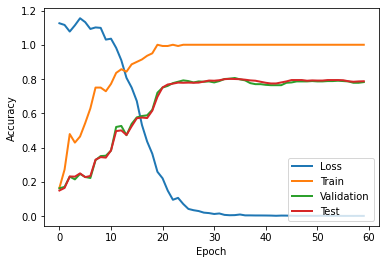

Best Validation Accuracy,  0.806
Best Test Accuracy,  0.801
0.801 60


In [41]:
# args.log_info = True
# args.recompute = False

# DATASET_NAME = 'Cora'
# data, dataset = get_data(DATASET_NAME,DIR=None, log=False, h_score=True, split_no=0)
# print(data)

# channel = 'all' #'all', 'hm', 'ht', 'sd'

# if DATASET_NAME in ['Squirrel', 'Chameleon']:
#     data.x = torch.cat((data.x, adj_feature(data)), dim=1)
#     if args.log_info == True:
#         print(data.x.shape)
    
# best_acc, num_iteration, _ =  AGSGSperformanceSampler(DATASET_NAME, data, dataset, dataset.num_classes,epochs=150, channel=channel)
# print(best_acc, num_iteration)

# Batch Experiments

In [42]:
def batch_experiments(num_run=1, channel='all'):
    
    ALL_DATASETs= [
#         "Roman-empire","Texas","Squirrel","Chameleon",
#         "Cornell","Actor","Wisconsin","Flickr","Amazon-ratings","reed98","amherst41","genius",
#         "AmazonProducts",
#         "cornell5","penn94",
#         "johnshopkins55",
#         "Yelp",
#         "cora","Tolokers","Minesweeper",
#         "CiteSeer","Computers","PubMed","pubmed",
#         "Reddit",
#         "cora_ml","dblp",
#         "Reddit2",
#         "Cora","CS","Photo","Questions","Physics","citeseer",
        'pokec',
        'arxiv-year',
        'snap-patents',
        'twitch-gamer'
    ]
    
    #ALL_DATASETs= ["Cora"]    

    args.log_info = False
    
    filename = "Results/AGSGNNsaintCheb-GS-"+channel+".txt"
    
    for DATASET_NAME in ALL_DATASETs:  
        print(DATASET_NAME, end=' ')
                
        result_file = open(filename,'a+')        
        result_file.write(f'{DATASET_NAME} ')
        result_file.close()
                
        accs = []
        itrs = []
                
        for i in range(num_run):
            data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=False, split_no=i, random_state=i)   
            
#             if data.num_nodes>100000:
#                 accs.append(-1)
#                 itrs.append(-1)
#                 break
            
            if len(data.y.shape) > 1:
                data.y = data.y.argmax(dim=1)        
                num_classes = torch.max(data.y).item()+1
            else:
                num_classes = dataset.num_classes
            
            if num_classes!= torch.max(data.y)+1:
                num_classes = torch.max(data.y).item()+1
                
            if data.num_nodes<100000:
                max_epochs = 150
            else:
                max_epochs = 50
                
            if DATASET_NAME in ['Squirrel', 'Chameleon', 
                                'cornell5','penn94','johnshopkins55'
                               ]:
                data.x = torch.cat((data.x, adj_feature(data)), dim=1)
                if args.log_info == True:
                    print(data.x.shape)
                              
            accuracy, itr, _ = AGSGSperformanceSampler(DATASET_NAME, data, dataset, num_classes,epochs=max_epochs, channel=channel)
            
            accs.append(accuracy)
            itrs.append(itr)
            #print(itr, accuracy)
                        
        #print(accs, itrs)
        print(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}')
        result_file = open(filename,'a+')
        result_file.write(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}\n')
        result_file.close()
                

start = time.time()
batch_experiments(num_run=1, channel='all')
end = time.time()
print("Time spent:", end-start)

pokec 

KeyboardInterrupt: 

## Visualize representation

In [39]:
if __name__ == '__main__':    
    
#     n=7
#     x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
#     y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
#     edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
#     edge_index = edge_index-1
    
#     mask = torch.zeros(n, dtype=torch.bool)
#     mask[[1,3]] = True
    
#     test_data = Data(x = x, y = y, edge_index = edge_index, train_mask = mask, test_mask = mask, val_mask = mask)    
#     print(test_data)
    
    
    None

In [40]:
# class AGS_layer(torch.nn.Module):
#     def __init__(self, input_channels, output_channels, dropout=0.2):
#         super().__init__()
#         self.T = 3
#         self.p = dropout
#         #self.Aconv1 = GCNConv(input_channels, output_channels)        
#         #self.Sconv1 = SpatialConv(input_channels, output_channels)
        
#         self.Aconv1 = GCNConv(input_channels, output_channels)
#         self.Sconv1 = SpatialConv(input_channels, output_channels)
        
#         self.I1 = nn.Linear(input_channels, output_channels)
        
#         self.layer_norm_a1 =  nn.LayerNorm(output_channels)
#         self.layer_norm_s1 =  nn.LayerNorm(output_channels)
#         self.layer_norm_i1 =  nn.LayerNorm(output_channels)
        
#         self.alpha_a1 = nn.Linear(output_channels, 1)
#         self.alpha_s1 = nn.Linear(output_channels, 1)
#         self.alpha_i1 = nn.Linear(output_channels, 1)
#         self.w1 = nn.Linear(3, 3)
        
#         #self.reset_parameters()
            
#     def reset_parameters(self):
        
#         stdv = 1. / math.sqrt(self.I1.weight.size(1))
#         std_att = 1. / math.sqrt(self.w1.weight.size(1))
#         std_att_vec = 1. / math.sqrt( self.alpha_a1.weight.size(1))
        
#         self.I1.weight.data.uniform_(-stdv, stdv)
        
#         self.alpha_a1.weight.data.uniform_(-std_att, std_att)
#         self.alpha_s1.weight.data.uniform_(-std_att, std_att)
#         self.alpha_i1.weight.data.uniform_(-std_att, std_att)
        
#         self.w1.weight.data.uniform_(-std_att_vec, std_att_vec)
        
#         self.layer_norm_a1.reset_parameters()
#         self.layer_norm_s1.reset_parameters()
#         self.layer_norm_i1.reset_parameters()
        

#     def forward(self, x0, edge_index, edge_weight=None):
#         a1 = F.relu(self.Aconv1(x0, edge_index, edge_weight))
#         a1 = self.layer_norm_a1(a1)
#         a1 = F.dropout(a1, p=self.p, training=self.training)
        
#         s1 = F.relu(self.Sconv1(x0, edge_index, edge_weight))
#         s1 = self.layer_norm_s1(s1)
#         s1 = F.dropout(s1, p=self.p, training=self.training)

#         i1 = F.relu(self.I1(x0))
#         i1 = self.layer_norm_i1(i1)
#         i1 = F.dropout(i1, p=self.p, training=self.training)
        
#         ala1 = torch.sigmoid(self.alpha_a1(a1))
#         als1 = torch.sigmoid(self.alpha_s1(s1))
#         ali1 = torch.sigmoid(self.alpha_i1(i1))        
#         alpha1 = F.softmax(self.w1(torch.cat([ala1, als1, ali1],dim=-1)/self.T), dim=1)        
        
#         x1 = torch.mm(torch.diag(alpha1[:,0]),a1) + torch.mm(torch.diag(alpha1[:,1]),s1) + torch.mm(torch.diag(alpha1[:,2]),i1)                
        
#         return x1
        
# class AGS_GCN(torch.nn.Module):
#     def __init__(self, num_features, num_classes, hidden_channels=16, dropout=0.2):
#         super().__init__()        
#         self.num_classes = num_classes
#         self.p = dropout
        
#         self.ags_layer1 = AGS_layer(num_features, hidden_channels)
#         self.ags_layer2 = AGS_layer(hidden_channels, hidden_channels)
#         #self.ags_layer2 = AGS_layer(hidden_channels, num_classes)
                
#         self.CombineW = nn.Linear(2 * hidden_channels, hidden_channels)
#         self.PredW = nn.Linear(1*hidden_channels, num_classes)
        
    
#     def forward(self, x0, edge_index, edge_weight=None):
        
#         #x0 = F.dropout(x0, p=self.p, training=self.training)
#         x1 = self.ags_layer1(x0, edge_index, edge_weight)
#         x1 = F.dropout(x1, p=self.p, training=self.training)
        
#         x2 = self.ags_layer2(x1, edge_index, edge_weight)
#         x2 = F.dropout(x2, p=self.p, training=self.training)        
        
#         #x = self.PredW(torch.cat([x1, x2], dim=-1))
#         x = self.PredW(x2)
         
#         #return x
#         return x.log_softmax(dim=-1)